# data prepare

In [3]:
### EDA

### collect the data
import glob
import os
import re
file_list = glob.glob(os.path.join('/kaggle/input/calltext/', "transcripts_v2", "*.txt")) # get the file name list
file_list = sorted(file_list, key=lambda f: int(f.replace('_','.').split('.')[2])) # sort the file name with order of number
corpus = [] # colloct all the transcripts
for file_path in file_list:
    with open(file_path) as f_input:
        corpus.append(f_input.read())

In [4]:
## the longest document
print('the len and index: ', len(max(corpus, key=len)),  corpus.index(max(corpus, key=len)))

the len and index:  3805 192


In [5]:

corpus=[w.replace('Customer Support', 'PA Agent') for w in corpus]
corpus=[w.replace('\n\n', '\n') for w in corpus]

# LLM model prep

In [ ]:
# LLM for sentiment analysis, here we use unsloth framework for running LLM models

#install the framework
!pip install pip3-autoremove;
!pip-autoremove torch torchvision torchaudio -y;
!pip install unsloth;

In [7]:
#### Load pre-trained model 
####https://github.com/unslothai/unsloth

from unsloth import FastLanguageModel
import torch
max_seq_length = 3092 # Choose a number
dtype = None # None for auto detection. 
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models 
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit", # the model used
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla P100-PCIE-16GB. Max memory: 15.888 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 6.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((40

# Prompting inference

In [13]:
## test the model with prompt input

##alpaca prompt formating
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:{}

### Input:{}

### Response:{}

"""
## test input
test_input = """AXA is an insurance company having business in comercial, retail, healthcare tec"""
test_instruction = """Which company is it? """
## run the test
inputs = tokenizer([alpaca_prompt.format(test_instruction, test_input, "")], return_tensors = "pt").to("cuda")
gen_tokens = model.generate(**inputs, max_new_tokens = 2)
outputs=tokenizer.batch_decode(gen_tokens)[0]
print(outputs)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:Which company is it? 

### Input:AXA is an insurance company having business in comercial, retail, healthcare tec

### Response:

AXA


In [14]:
def prompt_inference(input_data):
    instructions = input_data["instruction"]
    inputs       = input_data["input"]
    outputs      = input_data["output"]
    responseonly = []
    results = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        alpaca_text = alpaca_prompt.format(instruction, input, output) 
        token_inputs = tokenizer(alpaca_text , return_tensors = "pt").to("cuda")
        gen_tokens = model.generate(**token_inputs, max_new_tokens = 2)
       
        outs = tokenizer.batch_decode(gen_tokens)[0]
        results.append(outs.replace(tokenizer.eos_token, ""))
       
        outs = tokenizer.batch_decode(gen_tokens[:, token_inputs.input_ids.shape[1]:])[0]
        responseonly.append(outs.replace(tokenizer.eos_token, ""))
    print('inference done')
    return  results, responseonly

In [15]:
## zero shot prompt
## start to inference the sentiment, zero shot 
sent_instruct="identify the overall sentiment of Member from the conversation between Member and PA Agent, anwser with only one word from positive,negative or neutral, no empty answer"
action_instruct="analyse the conversation between Member and PA Agent, determine if there is a  follow-up action needed from the conversation, answer with either yes or no"
sent_data={"instruction": [sent_instruct]*len(corpus),  "input":corpus, 'output':[""]*len(corpus)}
action_data={"instruction": [action_instruct]*len(corpus),  "input":corpus, 'output':[""]*len(corpus)}

In [16]:
## for sentiment classification prediction
sent_results, sent_responseonly=prompt_inference(sent_data)

inference done


In [17]:
sent_responseonly

['Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neut',
 'Positive',
 'Neut',
 'Neut',
 'Neut',
 'Positive',
 'Neut',
 'Neut',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Neut',
 'Negative',
 'Negative',
 'Negative',
 'Neut',
 'Negative',
 'Neut',
 'Negative',
 'Positive',
 'Neut',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neut',
 'Positive',
 'Positive',
 'Neut',
 'Positive',
 'Positive',
 'Neut',
 'Positive',
 'neutral',
 'Neut',
 'Positive',
 'Neut',
 'Negative',
 'Negative',
 'Negative',
 'Neut',
 'Neut',
 'Negative',
 'Negative',
 'Neut',
 'Neut',
 'Negative',
 'Neut',
 'Neut',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neut',
 'Neut',
 'Neut',
 'Neut',
 'Positive',
 'Positive',
 'Positive',
 'neutral

In [18]:
## for follow-up classification prediction
action_results, action_responseonly=prompt_inference(action_data)

inference done


In [19]:
#print(set(action_responseonly))
action_responseonly


['Yes.',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'No,',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'Yes.',
 'No,',
 'Yes.',
 'Yes.',
 'Yes.',

In [20]:
print(set(sent_responseonly))
print(sent_responseonly.index('Relie'))
corpus[sent_responseonly.index('Relie')]

{'Neut', 'neutral', 'Positive', 'Negative', 'Relie'}
192


"Member: Hi, I'm calling to get a case pre-authorized for an upcoming surgery. My name is Emily Wilson and my member ID is MEM123456.\nPA Agent: Thank you for calling, Emily. I'd be happy to help you with that. Can you please confirm your date of birth and the type of surgery you're scheduled for?\nMember: My date of birth is March 12, 1985, and I'm scheduled for a knee replacement surgery on April 15th.\nPA Agent: Okay, thank you. Can you please tell me a little bit more about your current health situation and why you need this surgery?\nMember: (sighs) Yeah... I've been dealing with chronic pain in my knee for years, and it's gotten to the point where I can barely walk without pain. My doctor says I need the surgery to replace the damaged cartilage.\nPA Agent: I understand. I'm going to go ahead and check on your eligibility for pre-authorization. (pause) Okay, it looks like you do have coverage for this type of procedure, but I need to confirm a few more details. Can you please tell

# calculate performance

In [21]:
import pandas as pd
from sklearn import metrics 
import matplotlib.pyplot as plt


In [22]:
# read the ground truth
labels=pd.read_excel('/kaggle/input/labels/newlabels50.xlsx')
gt=labels.iloc[:,1].to_list()
print(set(gt))

{'neutral', 'positive', 'negative'}


In [23]:
sent_response=[w.replace('Neut', 'neutral').lower() for w in sent_responseonly]


In [24]:
performance=metrics.confusion_matrix(sent_response[0:50], gt)
print(metrics.classification_report(sent_response[0:50], gt))


              precision    recall  f1-score   support

    negative       0.70      0.94      0.80        17
     neutral       0.71      0.33      0.45        15
    positive       0.75      0.83      0.79        18

    accuracy                           0.72        50
   macro avg       0.72      0.70      0.68        50
weighted avg       0.72      0.72      0.69        50



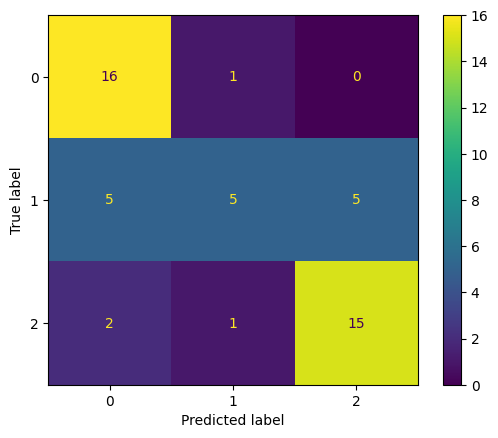

In [25]:
cm = metrics.confusion_matrix(sent_response[0:50], gt) 
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Further Analysis

In [26]:

import seaborn as sns

In [27]:
# check the percentage of the class
classcount=[sent_response.count(w)/len(sent_response) for w in {'negative', 'neutral', 'positive'}]
classcount

[0.28703703703703703, 0.25, 0.4583333333333333]

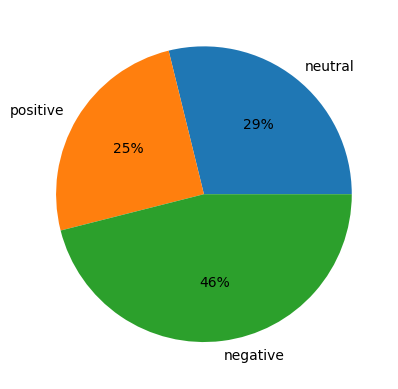

In [28]:
plt.pie(classcount, labels = {'negative', 'neutral', 'positive'}, autopct='%.0f%%')
plt.show()

In [30]:
## remove any text not from Member or PA agent
corpus_split=[w.split('\n') for w in corpus]
substrings=['Member', 'PA Agent' ]
corpus_remove= []
for sublist in corpus_split:
    sublist_remove=[item  for item in sublist if any(sub in item for sub in substrings)]
    corpus_remove.append(sublist_remove)

In [31]:
## get transcript for positive and negative respectively
positive_indexes = [i for i, x in enumerate(sent_response) if x == 'positive']
negative_indexes = [i for i, x in enumerate(sent_response) if x == 'negative']

In [32]:
corpus_corpus_remove_positive = [ corpus_remove[i] for i in positive_indexes]
corpus_corpus_remove_negative = [ corpus_remove[i] for i in negative_indexes]

In [33]:
## get the text from member and agent respectively
corpus_corpus_remove_positive_member=[]
corpus_corpus_remove_positive_agent=[]
substrings=['PA Agent:']
for sublist in corpus_corpus_remove_positive:
    sublist_member=[item  for item in sublist if not any(sub in item for sub in substrings)]
    sublist_agent=[item  for item in sublist if any(sub in item for sub in substrings)]
    corpus_corpus_remove_positive_member.append(sublist_member)
    corpus_corpus_remove_positive_agent.append(sublist_agent)



corpus_corpus_remove_negative_member=[]
corpus_corpus_remove_negative_agent=[]
substrings=['PA Agent:']
for sublist in corpus_corpus_remove_negative:
    sublist_member=[item  for item in sublist if not any(sub in item for sub in substrings)]
    sublist_agent=[item  for item in sublist if any(sub in item for sub in substrings)]
    corpus_corpus_remove_negative_member.append(sublist_member)
    corpus_corpus_remove_negative_agent.append(sublist_agent)




In [51]:
# Function to count words in a sentence
def count_words(sentence):
    return len(sentence.split())

# Count total words 
total_words_positive_memember = sum(count_words(sentence) for sublist in corpus_corpus_remove_positive_member for sentence in sublist)
total_words_positive_agent = sum(count_words(sentence) for sublist in corpus_corpus_remove_positive_agent for sentence in sublist)
total_words_negative_memember = sum(count_words(sentence) for sublist in corpus_corpus_remove_negative_member for sentence in sublist)
total_words_negative_agent = sum(count_words(sentence) for sublist in corpus_corpus_remove_negative_agent for sentence in sublist)

In [54]:
lenp=len(positive_indexes)
lenn=len(negative_indexes)
print(total_words_positive_memember,total_words_positive_agent,total_words_negative_memember,total_words_negative_agent)
print(total_words_positive_memember/total_words_positive_agent,total_words_negative_memember/total_words_negative_agent)
print(total_words_positive_memember/lenp,total_words_positive_agent/lenp,total_words_negative_memember/lenn,total_words_negative_agent/lenn)

7129 13750 15340 26739
0.5184727272727273 0.5736938554171809
132.0185185185185 254.62962962962962 154.94949494949495 270.09090909090907


Text(0, 0.5, 'Number of Words')

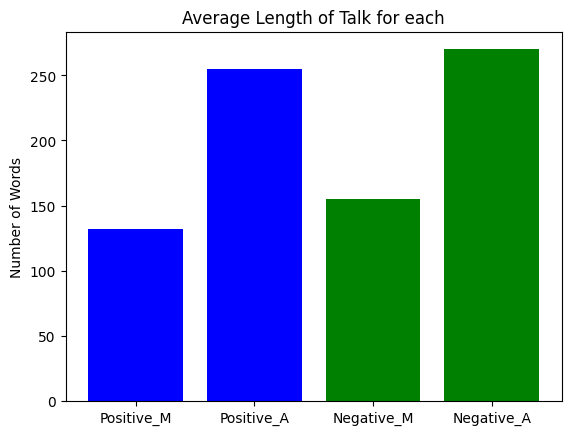

In [64]:
# Data
categories = ['Positive_M','Positive_A','Negative_M', 'Negative_A']
values = [total_words_positive_memember/lenp,total_words_positive_agent/lenp,total_words_negative_memember/lenn,total_words_negative_agent/lenn]  # 
colors = ['blue', 'blue','green', 'green']  # Colors for each bar
# Create bar chart
plt.bar(categories, values, color=colors)
# Add title and labels
plt.title('Average Length of Talk for each')
plt.ylabel('Number of Words')


Text(0, 0.5, 'Ratio')

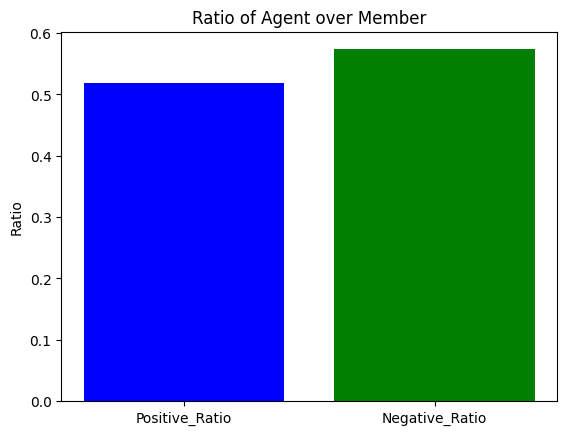

In [66]:
# Show plot
categories = ['Positive_Ratio','Negative_Ratio']
values = [total_words_positive_memember/total_words_positive_agent,total_words_negative_memember/total_words_negative_agent]
colors = ['blue', 'green']  # Colors for each bar
# Create bar chart
plt.bar(categories, values, color=colors)
# Add title and labels
plt.title('Ratio of Agent over Member')
plt.ylabel('Ratio')

In [34]:
# Extract strings within brackets and check them for positive and negative respectively
corpus_bracket=[]
for sublist in corpus_remove:
    extract=[item[item.find("(")+1:item.find(")")] for item in sublist if "(" in item and ")" in item]
    corpus_bracket.append(extract)


In [35]:
substrings=['pause', 'after','MEM' ,'hands','check','hangs up']
corpus_bracket_remove=[]
for sublist in corpus_bracket:
    sublist_remove=[item  for item in sublist if not any(sub in item for sub in substrings)]
    corpus_bracket_remove.append(sublist_remove)

In [36]:

corpus_bracket_remove_positive = [ corpus_bracket_remove[i] for i in positive_indexes]
corpus_bracket_remove_negative = [ corpus_bracket_remove[i] for i in negative_indexes]


In [37]:
flat_bracket=[item for sublist in corpus_bracket_remove  for item in sublist]
flat_bracket_negative=[item for sublist in corpus_bracket_remove_negative  for item in sublist]
flat_bracket_positive=[item for sublist in corpus_bracket_remove_positive  for item in sublist]


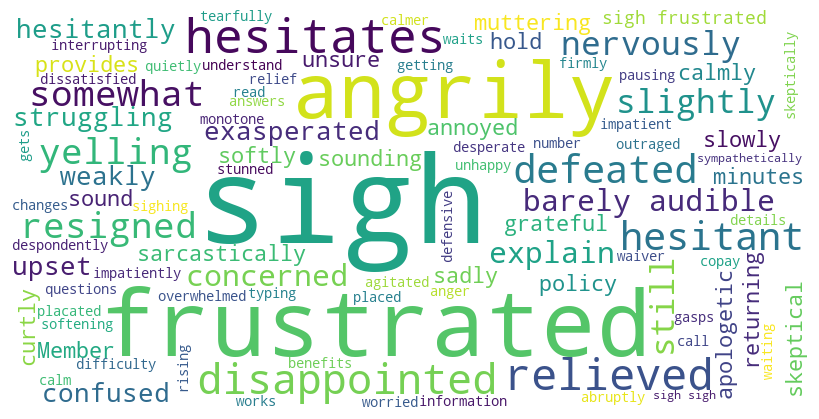

In [38]:
from wordcloud import WordCloud

# Convert list to a string
words_string = ' '.join(flat_bracket)
words_string1 = ' '.join(flat_bracket_negative)
words_string2 = ' '.join(flat_bracket_positive)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(words_string)
wordcloud1 = WordCloud(width=800, height=400, background_color ='white').generate(words_string1)
wordcloud2 = WordCloud(width=800, height=400, background_color ='white').generate(words_string2)
# Plot word cloud
plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


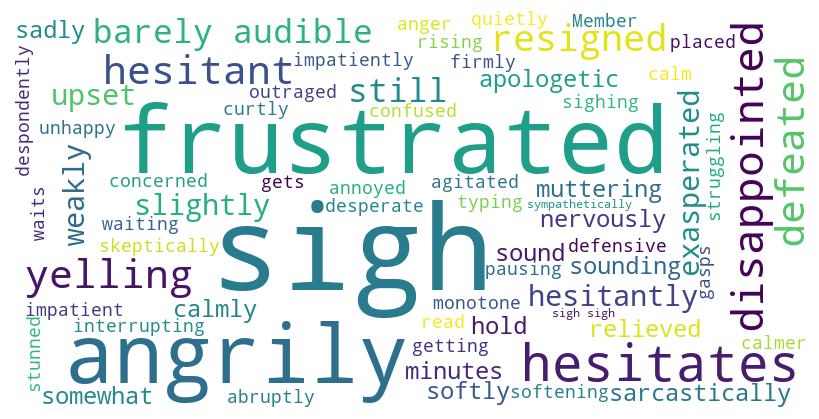

In [39]:
plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


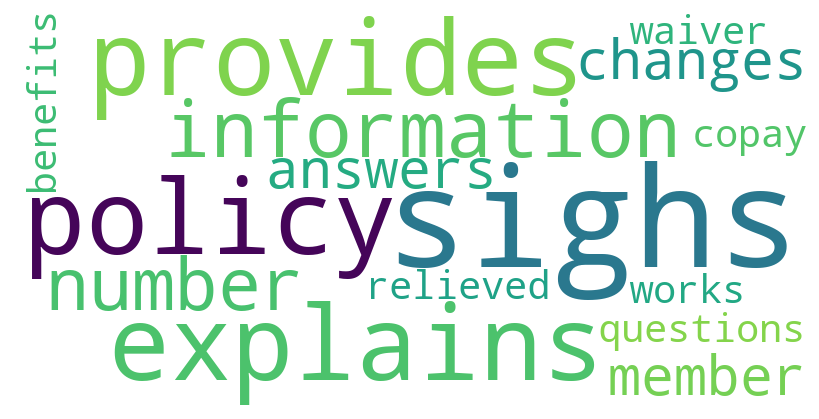

In [40]:
plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [41]:

# create a dataframe for convenience for further analysis if any
index=range(len(sent_response))

# Create DataFrame
df = pd.DataFrame(list(zip(index, corpus,corpus_bracket_remove,sent_response)), columns=['No', 'transcripts', 'bracket','sentiment'])

In [42]:
df.head()

,No,transcripts,bracket,sentiment
0,0,"Member: Hi, I'm calling to get a case pre-auth...",[],positive
1,1,"Member: Hi, I'm calling to schedule an appoint...",[],positive
2,2,"Member: Hi, I'm calling about my recent bill f...",[],positive
3,3,"Member: Hi, I'm calling about a denied claim I...",[],positive
4,4,"Member: Hi, I'm calling to get a case pre-auth...",[],neutral


# Supervised fine tuning with PEFT  with lora approach, not finished yet due to lack of data

In [43]:
# get model with lora parameters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # 4x longer contexts auto supported!
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# prepare data set
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset

dataset = load_dataset(corpus, split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
# use Huggingface TRL's SFTTrainer to train the model

from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

In [ ]:
# train the model
trainer_stats = trainer.train()